In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

nakaza = pd.read_csv('https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/nakazeni-vyleceni-umrti-testy.csv', 
                     parse_dates=['datum'], index_col=['datum'])
nakaza['smrtnost [%]'] = 100 * nakaza['kumulativni_pocet_umrti'] / nakaza['kumulativni_pocet_nakazenych']


# Filter out messy data
nakaza = nakaza.loc['2020-03-01':]
# See Sweden study
# https://www.folkhalsomyndigheten.se/contentassets/53c0dc391be54f5d959ead9131edb771/infection-fatality-rate-covid-19-stockholm-technical-report.pdf
IFR1 = 0.3 # lower bound [percent]
IFR2 = 0.8 # upper bound [percent]
nakaza['smrtnost [%] (15 dnu prodleva)'] = 100 * nakaza['kumulativni_pocet_umrti'].shift(periods=-15, fill_value=0) /  nakaza['kumulativni_pocet_nakazenych']
nakaza['smrtnost [%] (21 dnu prodleva)'] = 100 * nakaza['kumulativni_pocet_umrti'].shift(periods=-21, fill_value=0) /  nakaza['kumulativni_pocet_nakazenych']
nakaza['r15_0.3'] = nakaza['smrtnost [%] (15 dnu prodleva)'] / IFR1
nakaza['r21_0.3'] = nakaza['smrtnost [%] (21 dnu prodleva)'] / IFR1
nakaza['r15_0.8'] = nakaza['smrtnost [%] (15 dnu prodleva)'] / IFR2
nakaza['r21_0.8'] = nakaza['smrtnost [%] (21 dnu prodleva)'] / IFR2

# Fill zeros with last non-zero values, remember the death has a lag 15-21 days
nakaza['smrtnost [%] (15 dnu prodleva)']  = nakaza['smrtnost [%] (15 dnu prodleva)'].replace(to_replace=0, method='ffill')
nakaza['smrtnost [%] (21 dnu prodleva)']  = nakaza['smrtnost [%] (21 dnu prodleva)'].replace(to_replace=0, method='ffill')
nakaza['r15_0.3'] = nakaza['r15_0.3'].replace(to_replace=0, method='ffill')
nakaza['r15_0.8'] = nakaza['r15_0.8'].replace(to_replace=0, method='ffill')
nakaza['r21_0.3'] = nakaza['r21_0.3'].replace(to_replace=0, method='ffill')
nakaza['r21_0.8'] = nakaza['r21_0.8'].replace(to_replace=0, method='ffill')

nakaza['Infekcni15 0.3'] = nakaza['kumulativni_pocet_nakazenych'] * nakaza['smrtnost [%] (15 dnu prodleva)'] / IFR1
nakaza['Infekcni21 0.3'] = nakaza['kumulativni_pocet_nakazenych'] * nakaza['smrtnost [%] (21 dnu prodleva)'] / IFR1
nakaza['Infekcni15 0.8'] = nakaza['kumulativni_pocet_nakazenych'] * nakaza['smrtnost [%] (15 dnu prodleva)'] / IFR2
nakaza['Infekcni21 0.8'] = nakaza['kumulativni_pocet_nakazenych'] * nakaza['smrtnost [%] (21 dnu prodleva)'] / IFR2


nakaza.tail(50)

,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti,kumulativni_pocet_testu,smrtnost [%],smrtnost [%] (15 dnu prodleva),smrtnost [%] (21 dnu prodleva),r15_0.3,r21_0.3,r15_0.8,r21_0.8,Infekcni15 0.3,Infekcni21 0.3,Infekcni15 0.8,Infekcni21 0.8
datum,,,,,,,,,,,,,,,
2020-09-04,27234,19903,434,961150,1.593596,1.913050,2.181097,6.376833,7.270324,2.391312,2.726371,1.736667e+05,1.980000e+05,65125.000000,74250.000000
2020-09-05,27739,20057,439,968616,1.582609,1.899852,2.199070,6.332841,7.330233,2.374815,2.748837,1.756667e+05,2.033333e+05,65875.000000,76250.000000
2020-09-06,28149,20169,442,973151,1.570216,1.925468,2.223880,6.418227,7.412934,2.406835,2.779850,1.806667e+05,2.086667e+05,67750.000000,78250.000000
2020-09-07,28710,20566,444,984728,1.546499,1.922675,2.218739,6.408917,7.395797,2.403344,2.773424,1.840000e+05,2.123333e+05,69000.000000,79625.000000
2020-09-08,29871,20883,449,1000823,1.503130,1.921596,2.202805,6.405321,7.342685,2.401995,2.753507,1.913333e+05,2.193333e+05,71750.000000,82250.000000
2020-09-09,31029,21260,452,1016297,1.456702,1.882110,2.168939,6.273701,7.229796,2.352638,2.711173,1.946667e+05,2.243333e+05,73000.000000,84125.000000
2020-09-10,32411,21791,457,1032595,1.410015,1.832711,2.165931,6.109037,7.219771,2.290889,2.707414,1.980000e+05,2.340000e+05,74250.000000,87750.000000
2020-09-11,33854,22625,460,1051787,1.358776,1.801855,2.135641,6.006183,7.118804,2.252319,2.669552,2.033333e+05,2.410000e+05,76250.000000,90375.000000
2020-09-12,35391,23306,466,1064844,1.316719,1.768811,2.079625,5.896038,6.932083,2.211014,2.599531,2.086667e+05,2.453333e+05,78250.000000,92000.000000


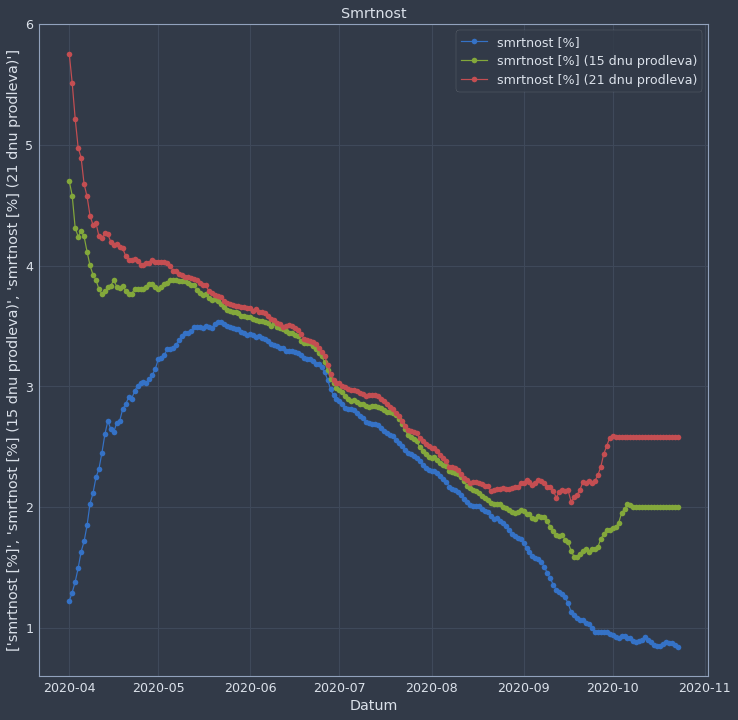

In [28]:
df = nakaza.loc['2020-04-01':]


def cplot(df, column_str, title, bars=False, color=None):
    fig, ax = plt.subplots(figsize=(12, 12))
    clms = []
    if not isinstance(column_str, list):
        clms = [column_str]
    else:
        clms = column_str
        
    if bars:
        for c in clms:
            ax.bar(
                df.index.values,
                df[c],
                color=color
            )
    else:
        for c in clms:
            ax.plot(df.index.values,
               df[c],
               marker='o',
               color=color)

# Set title and labels for axes
    
    ax.set(xlabel="Datum",
       ylabel=column_str,
       title=title)
    ax.legend(clms)
    
    plt.show()

cplot(df, ['smrtnost [%]', 'smrtnost [%] (15 dnu prodleva)', 'smrtnost [%] (21 dnu prodleva)'], "Smrtnost", False)    
#df['prirustkovy_pocet_nakazenych'].plot(linewidth=1.5)

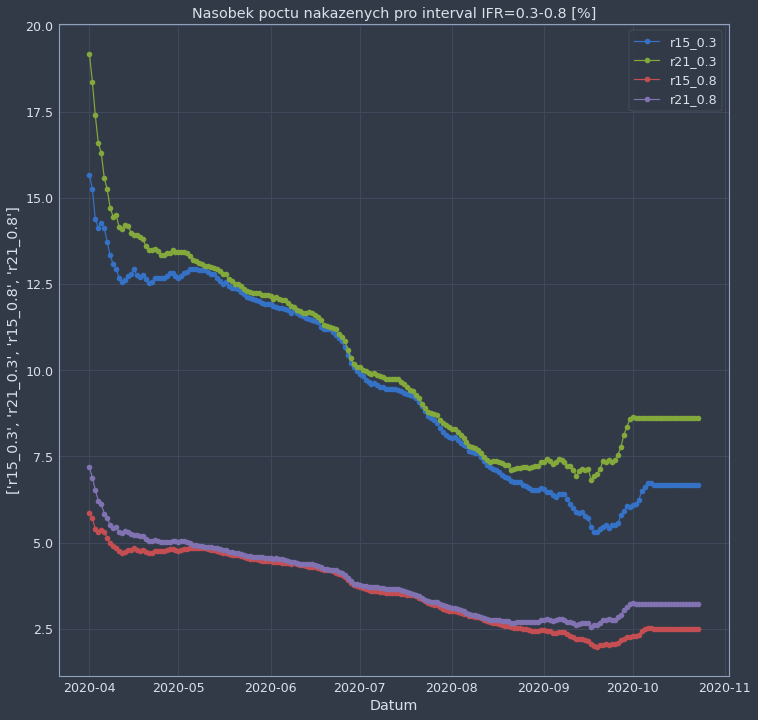

In [29]:
df = nakaza.loc['2020-04-01':]
cplot(df, ['r15_0.3', 'r21_0.3', 'r15_0.8', 'r21_0.8'], "Nasobek poctu nakazenych pro interval IFR="+str(IFR1)+"-"+str(IFR2)+" [%]")

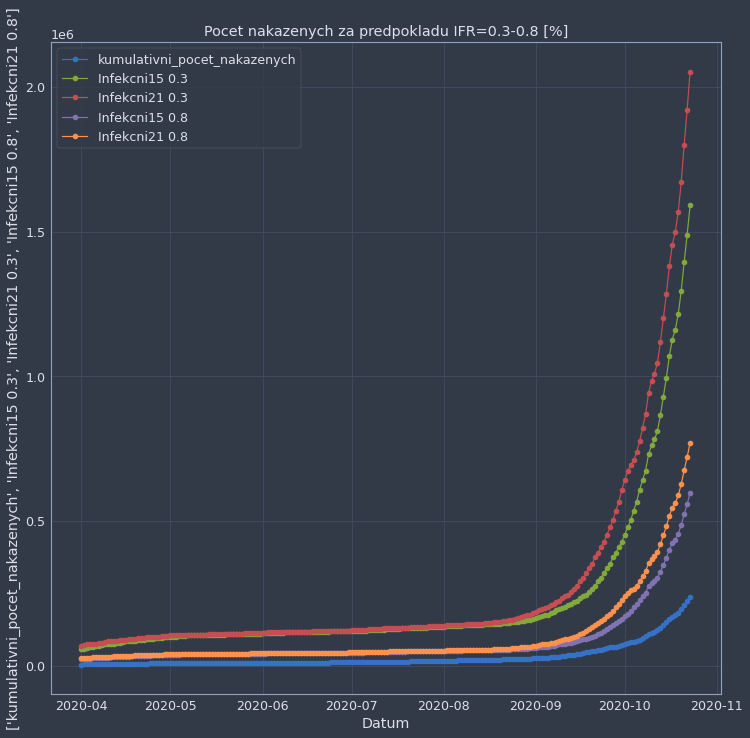

In [30]:
df = nakaza.loc['2020-04-01':]
cplot(df, ['kumulativni_pocet_nakazenych', 'Infekcni15 0.3', 'Infekcni21 0.3', 'Infekcni15 0.8', 'Infekcni21 0.8'], "Pocet nakazenych za predpokladu IFR="+str(IFR1)+"-"+str(IFR2)+" [%]")